# Animation in jupyter notebook

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import animation, rc
from IPython.display import HTML

from scipy import stats 
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

from sklearn.datasets.samples_generator import make_regression 

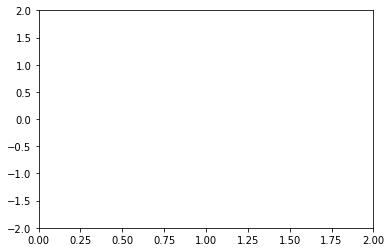

In [2]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

In [4]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [11]:
# animation function is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = 0.8*np.sin(2 * np.pi * (x - 0.01 * i)) + 0.2*np.sin(2 * np.pi * (x - 0.01 * i) * 10)
    line.set_data(x, y)
    return (line,)

In [12]:
# create animation object
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, 
                               blit=True # only re-draw the parts that have changed
                              )

In [13]:
HTML(anim.to_html5_video())

# Gradient Descent and SGD

## Example: Linear regression

$$f_\w (x) =w^T x$$

Loss:  
$$J(w) = \frac{1}{2} \sum_{i=1}^m (f_w (x_{i})-y_{i})^2$$


In [146]:
x, y = make_regression(n_samples = 100, 
                       n_features=1, 
                       n_informative=1, 
                       noise=20,
                       random_state=2017)

In [147]:
from sklearn.linear_model import LinearRegression


model = LinearRegression().fit(x,y)
model.coef_, model.intercept_

(array([82.90456142]), -3.709228868670302)

In [148]:
x = x.flatten()
best_fit = np.vectorize(lambda x: x * model.coef_[0] + model.intercept_)

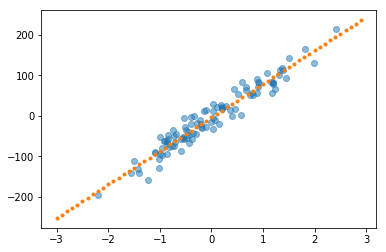

In [149]:
plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,best_fit(grid), '.')

## Batch gradient descent

$$J(w) =\sum_{i=1}^m J_i(w)$$

where $J_i$ is associated with the i-th observation in our data set. Given some initial feasible  $w$ (which we can either fix or assign randomly) and then repeatedly performs the update:

$$w := w - \eta \nabla_{w} J(w) = w -\eta \sum_{i=1}^m \nabla J_i(w)$$

where $\eta$ is a constant controlling step-size and is called the learning rate.

Batch gradient descent is guaranteed to converge to the global minimum for convex error surfaces and to a local minimum for non-convex surfaces.

In the given example the update step takes the form:

$$ w_j := w_j + \alpha \sum_{i=1}^m (y_{i} - f_w (x_{i})) x_{i,j}$$

In [150]:
def gradient_descent(x, y, theta_init, step=0.001, maxsteps=0, precision=0.001, ):
    costs = []
    m = y.size # number of data points
    theta = theta_init
    history = [] # to store all thetas
    preds = []
    counter = 0
    oldcost = 0
    pred = np.dot(x, theta)
    error = pred - y 
    currentcost = np.sum(error ** 2) / (2 * m)
    preds.append(pred)
    costs.append(currentcost)
    history.append(theta)
    counter+=1
    while abs(currentcost - oldcost) > precision:
        oldcost=currentcost
        gradient = x.T.dot(error)/m 
        theta = theta - step * gradient  # update
        history.append(theta)
        
        pred = np.dot(x, theta)
        error = pred - y 
        currentcost = np.sum(error ** 2) / (2 * m)
        costs.append(currentcost)
        
        if counter % 25 == 0: preds.append(pred)
        counter+=1
        if maxsteps:
            if counter == maxsteps:
                break
        
    return history, costs, preds, counter

In [151]:
np.random.rand(2)

array([0.83758949, 0.33615587])

In [152]:
xaug = np.c_[np.ones(x.shape[0]), x]
theta_i = [-15, 40] + np.random.rand(2)
history, cost, preds, iters = gradient_descent(xaug, y, theta_i)
theta = history[-1]

In [153]:
print("Gradient Descent: {:.2f}, {:.2f} {:d}".format(theta[0], theta[1], iters))
print("Least Squares: {:.2f}, {:.2f}".format(model.intercept_, model.coef_[0]))

Gradient Descent: -3.93, 81.67 4447
Least Squares: -3.71, 82.90


One can plot the reduction of loss:

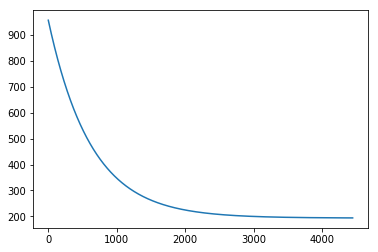

In [154]:
plt.plot(range(len(cost)), cost);

The following animation shows how the regression line forms:

In [155]:
from IPython.display import HTML

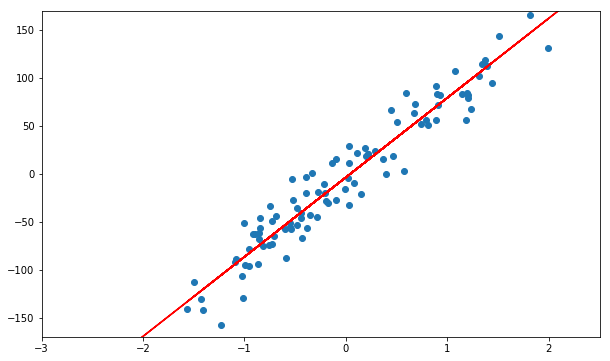

In [156]:
def init():
    line.set_data([], [])
    return line,

def animate(i):
    ys = preds[i]
    line.set_data(xaug[:, 1], ys)
    return line,



fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(-3, 2.5), ylim=(-170, 170))
ax.plot(xaug[:,1],y, 'o')
line, = ax.plot([], [], lw=2)
plt.plot(xaug[:,1], best_fit(xaug[:,1]), 'k-', color = "r")

anim = animation.FuncAnimation(fig, animate, init_func=init,
                        frames=len(preds), interval=100)


HTML(anim.to_html5_video())

Remember that the linear regression cost function is convex, and more precisely quadratic. We can see the path that gradient descent takes in arriving at the optimum:

In [157]:
from mpl_toolkits.mplot3d import Axes3D

def error(X, Y, THETA):
    return np.sum((X.dot(THETA) - Y)**2)/(2*Y.size)

def make_3d_plot(xfinal, yfinal, zfinal, hist, cost, xaug, y):
    ms = np.linspace(xfinal - 20 , xfinal + 20, 20)
    bs = np.linspace(yfinal - 40 , yfinal + 40, 40)
    M, B = np.meshgrid(ms, bs)
    zs = np.array([error(xaug, y, theta) 
                   for theta in zip(np.ravel(M), np.ravel(B))])
    Z = zs.reshape(M.shape)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.1)
    ax.contour(M, B, Z, 20, color='b', alpha=0.5, offset=0, stride=30)
    ax.set_xlabel('Intercept')
    ax.set_ylabel('Slope')
    ax.set_zlabel('Cost')
    ax.view_init(elev=30., azim=30)
    ax.plot([xfinal], [yfinal], [zfinal] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);
    ax.plot([t[0] for t in hist], [t[1] for t in hist], cost , markerfacecolor='b', markeredgecolor='b', marker='.', markersize=5);
    ax.plot([t[0] for t in hist], [t[1] for t in hist], 0 , alpha=0.5, markerfacecolor='r', markeredgecolor='r', marker='.', markersize=5)
    
def gd_plot(xaug, y, theta, cost, hist):
    make_3d_plot(theta[0], theta[1], cost[-1], hist, cost, xaug, y)

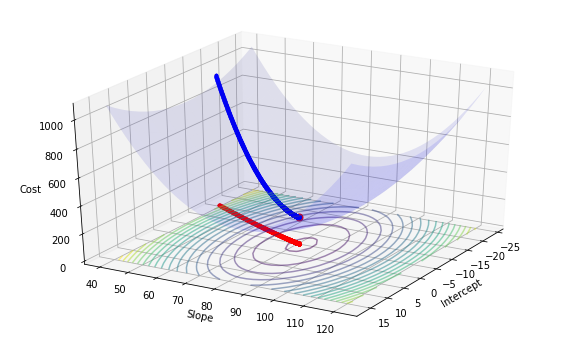

In [158]:
gd_plot(xaug, y, theta, cost, history)

## Stochastic gradient descent

When we have very large data sets, the calculation of $\nabla J(w)$ can be costly as we must process every data point before making a single step (hence the name "batch"). An alternative approach, the stochastic gradient descent method, is to update $w$ sequentially with every observation. The updates then take the form:

$$w := w - \alpha \nabla_{w} J_i(w)$$

This stochastic gradient approach allows us to start making progress on the minimization problem right away. It is computationally cheaper, but it results in a larger variance of the loss function in comparison with batch gradient descent. 

Generally, the stochastic gradient descent method will get close to the optimal $w$ much faster than the batch method, but will never fully converge to the local (or global) minimum. Thus the stochastic gradient descent method is useful when we want a quick and dirty approximation for the solution to our optimization problem. 
    
The reshuffling of the data is done to avoid a bias in the optimization algorithm by providing the data examples in a particular order. 

For a given epoch, we first reshuffle the data, and then for a single example, we evaluate the gradient of the loss function and then update the params with the chosen learning rate.

The update for linear regression is:

$$w_j := w_j + \alpha (y_{i}-f_w (x_{i})) x_{j,i}$$


In [160]:
def sgd(x, y, theta_init, step=0.001, maxsteps=0, precision=0.001, ):
    costs = []
    currentcosts = []
    m = y.size # number of data points
    oldtheta = 0
    theta = theta_init
    history = [] # to store all thetas
    preds = []
    grads = []
    xs = []
    ys = []
    counter = 0
    oldcost = 0
    epoch = 0
    i = 0 #index
    xs.append(x[i,:])
    ys.append([y[i]])
    pred = np.dot(x[i,:], theta)
    error = pred - y[i]
    gradient = x[i,:].T*error
    grads.append(gradient)
    currentcost = np.sum(error ** 2) / 2
    print("Init", gradient, x[i,:],y[i])
    print ("Init2", currentcost, theta)
    currentcosts.append(currentcost)
    counter+=1
    preds.append(pred)
    costsum = currentcost
    costs.append(costsum/counter)
    history.append(theta)
    print("start",counter, costs, oldcost)
    while 1:
        #while abs(costs[counter-1] - oldcost) > precision:
        #while np.linalg.norm(theta - oldtheta) > precision:
        gradient = x[i,:].T*error
        grads.append(gradient)
        oldtheta = theta
        theta = theta - step * gradient  # update
        history.append(theta)
        i += 1
        if i == m:#reached one past the end.
            #break
            epoch +=1
            neworder = np.random.permutation(m)
            x = x[neworder]
            y = y[neworder]
            i = 0
        xs.append(x[i,:])
        ys.append(y[i])
        pred = np.dot(x[i,:], theta)
        error = pred - y[i]
        currentcost = np.sum(error ** 2) / 2
        currentcosts.append(currentcost)
        
        #print("e/cc",error, currentcost)
        if counter % 25 == 0: preds.append(pred)
        counter+=1
        costsum += currentcost
        oldcost = costs[counter-2]
        costs.append(costsum/counter)
        #print(counter, costs, oldcost)
        if maxsteps:
            #print("in maxsteps")
            if counter == maxsteps:
                break
        
    return history, costs, preds, grads, counter, epoch, xs, ys, currentcosts

In [161]:
history2, cost2, preds2, grads2, iters2, epoch2, x2, y2, cc2 = sgd(xaug, y, theta_i, maxsteps=5000, step=0.01)


Init [-24.5117403   -0.79058763] [1.         0.03225343] 11.534851890155354
Init2 300.41270638610354 [-14.28420715  40.53270777]
start 1 [300.41270638610354] 0


In [162]:
print(iters2, history2[-1], epoch2, grads2[-1])

5000 [-3.91020531 82.57015473] 49 [10.15485159 -4.90006261]


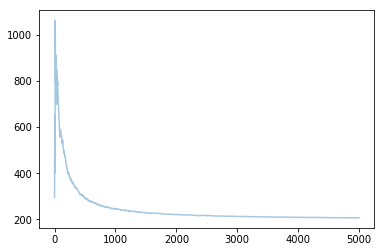

In [163]:
plt.plot(range(len(losses2[-10000:])), losses2[-10000:], alpha=0.4);

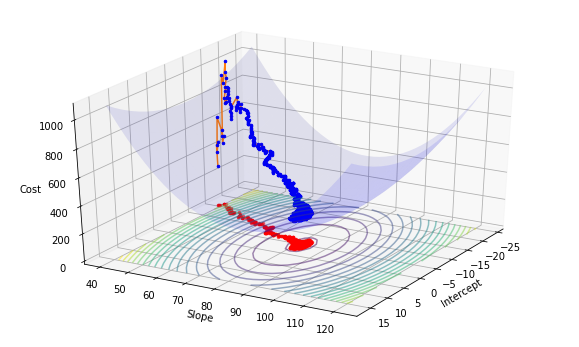

In [164]:
gd_plot(xaug, y, w, losses2, history2)

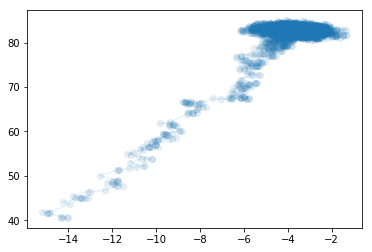

In [165]:
plt.plot([t[0] for t in history2], [t[1] for t in history2],'o-', alpha=0.1)

#### Animating SGD

Here is some code to make an animation of SGD. It shows how the risk surfaces being minimized change, and how the minimum desired is approached.

In [168]:
%%bash

rm -rf images
mkdir images
ls -l images

total 0


In [169]:
def error2(X, Y, THETA):
    return np.sum((X.dot(THETA) - Y)**2)/(2*Y.size)


def make_3d_plot2(num, it, xfinal, yfinal, zfinal, hist, cost, xaug, y):
    ms = np.linspace(xfinal - 20 , xfinal + 20, 20)
    bs = np.linspace(yfinal - 50 , yfinal + 50, 40)
    M, B = np.meshgrid(ms, bs)
    zs = np.array([error2(xaug, y, theta) 
                   for theta in zip(np.ravel(M), np.ravel(B))])
    Z = zs.reshape(M.shape)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.1)
    ax.contour(M, B, Z, 20, color='b', alpha=0.5, offset=0, stride=30)
    ax.set_xlabel('Intercept')
    ax.set_ylabel('Slope')
    ax.set_zlabel('Cost')
    ax.view_init(elev=30., azim=30)
    ax.plot([xfinal], [yfinal], [zfinal] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);
    ax.plot([t[0] for t in hist], [t[1] for t in hist], 0 , alpha=0.5, markerfacecolor='r', markeredgecolor='r', marker='.', markersize=5)
    ax.set_zlim([0, 3000])
    plt.title("Iteration {}".format(it))
    plt.savefig("images/3danim{0:03d}.png".format(num))
    plt.close()

In [170]:
print("fthetas",theta[0], theta[1], "len", len(history2))
ST = list(range(0, 750, 10)) + list(range(750, 5000, 250))
len(ST)

fthetas -3.925082217997683 81.67159845946831 len 5000


92

In [171]:
for i in tqdm(range(len(ST))):
    make_3d_plot2(i, ST[i], theta[0], theta[1], cost2[-1], [history2[ST[i]]], [cc2[ST[i]]], np.array([x2[ST[i]]]), np.array([y2[ST[i]]]))

100%|██████████| 92/92 [00:55<00:00,  1.64it/s]


In [172]:
!convert -delay 20 -loop 1 images/3danim*.png images/animsgd.gif

In [173]:
HTML("<img src=images/animsgd.gif />")